In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_19499/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


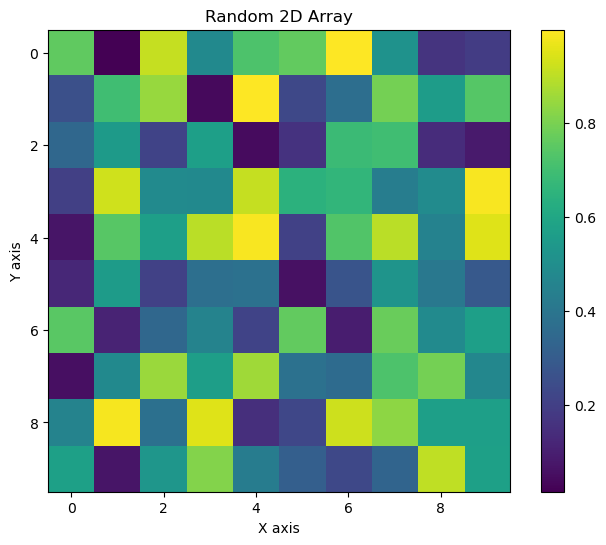

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    val_acc_best = 0
    val_acc_now = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (e_transport_swap > 0 or e_transport_swap_tr > 0):
            assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
            if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_val_best_growth_count = 0
            if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                no_tr_best_growth_count = 0

        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            val_loss=0
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter/val_loss:{loss:.3f}/{val_loss:.3f}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc_best:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                cfg = ['M','M','M',200,200],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.001, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 5, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = False, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                
                drop_rate = 0.0,

                exclude_class = True, # True # False # gesture에서 10번째 클래스 제외
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on False 

processing - exclude 'other' class
processing done - exclude 'other' class

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): DimChanger_for_FC_sstep()
      (4): SYNAPSE_FC_trace_sstep()
      (5): LIF_layer_trace_sstep()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 144,810, system's param_num : 144,810
Memory: 0.55MiB at 32-bit
EPOCH 0


0-61/62 iter:0.00%, lr=['0.001'], iter/val_loss:23.106/345.383, tr:8.58%, val:10.42%, val_best:10.42%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.86589956283569 seconds

EPOCH 1



1-61/62 iter:0.00%, lr=['0.000999972584682756'], iter/val_loss:23.128/342.483, tr:10.32%, val:15.00%, val_best:15.00%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.875025272369385 seconds

EPOCH 2



2-61/62 iter:66.67%, lr=['0.0009998903417374227'], iter/val_loss:20.594/310.285, tr:23.29%, val:37.50%, val_best:37.50%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.780946016311646 seconds

EPOCH 3



3-61/62 iter:33.33%, lr=['0.0009997532801828658'], iter/val_loss:19.025/267.884, tr:40.96%, val:44.17%, val_best:44.17%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.77546429634094 seconds

EPOCH 4



4-61/62 iter:33.33%, lr=['0.0009995614150494292'], iter/val_loss:18.902/250.892, tr:49.13%, val:42.92%, val_best:44.17%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.6563184261322 seconds

EPOCH 5



5-61/62 iter:66.67%, lr=['0.000999314767377287'], iter/val_loss:16.007/236.644, tr:55.06%, val:50.00%, val_best:50.00%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.3364782333374 seconds

EPOCH 6



6-61/62 iter:33.33%, lr=['0.0009990133642141358'], iter/val_loss:9.290/228.708, tr:59.35%, val:52.08%, val_best:52.08%: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]

epoch_time: 39.80378198623657 seconds

EPOCH 7



7-61/62 iter:100.00%, lr=['0.000998657238612229'], iter/val_loss:7.734/221.085, tr:61.39%, val:51.67%, val_best:52.08%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.21247959136963 seconds

EPOCH 8



8-61/62 iter:33.33%, lr=['0.0009982464296247522'], iter/val_loss:18.752/216.397, tr:60.98%, val:55.42%, val_best:55.42%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.735958099365234 seconds

EPOCH 9



9-61/62 iter:66.67%, lr=['0.00099778098230154'], iter/val_loss:8.829/212.206, tr:63.23%, val:56.25%, val_best:56.25%: 100%|██████████| 62/62 [00:39<00:00,  1.55it/s]

epoch_time: 40.16934943199158 seconds

EPOCH 10



10-61/62 iter:66.67%, lr=['0.0009972609476841367'], iter/val_loss:15.532/207.863, tr:64.25%, val:60.00%, val_best:60.00%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.599759101867676 seconds

EPOCH 11



11-61/62 iter:66.67%, lr=['0.0009966863828001983'], iter/val_loss:13.340/206.291, tr:65.78%, val:59.58%, val_best:60.00%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.47447633743286 seconds

EPOCH 12



12-61/62 iter:66.67%, lr=['0.0009960573506572392'], iter/val_loss:7.984/205.523, tr:66.60%, val:57.08%, val_best:60.00%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.257094860076904 seconds

EPOCH 13



13-61/62 iter:33.33%, lr=['0.000995373920235722'], iter/val_loss:16.835/203.982, tr:66.19%, val:62.50%, val_best:62.50%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.20662331581116 seconds

EPOCH 14



14-61/62 iter:100.00%, lr=['0.0009946361664814943'], iter/val_loss:3.460/202.372, tr:68.34%, val:62.50%, val_best:62.50%: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]

epoch_time: 40.73373007774353 seconds

EPOCH 15



15-61/62 iter:66.67%, lr=['0.000993844170297569'], iter/val_loss:11.555/201.666, tr:67.93%, val:62.08%, val_best:62.50%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.94757604598999 seconds

EPOCH 16



16-61/62 iter:66.67%, lr=['0.0009929980185352527'], iter/val_loss:9.722/201.435, tr:71.71%, val:62.08%, val_best:62.50%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.74763774871826 seconds

EPOCH 17



17-61/62 iter:66.67%, lr=['0.000992097803984621'], iter/val_loss:10.900/197.838, tr:69.46%, val:64.17%, val_best:64.17%: 100%|██████████| 62/62 [00:39<00:00,  1.55it/s]

epoch_time: 40.11871004104614 seconds

EPOCH 18



18-61/62 iter:66.67%, lr=['0.0009911436253643446'], iter/val_loss:10.445/197.305, tr:70.99%, val:65.83%, val_best:65.83%: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]

epoch_time: 39.75669741630554 seconds

EPOCH 19



19-61/62 iter:100.00%, lr=['0.0009901355873108612'], iter/val_loss:4.747/198.158, tr:71.91%, val:62.92%, val_best:65.83%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.86238956451416 seconds

EPOCH 20



20-61/62 iter:66.67%, lr=['0.000989073800366903'], iter/val_loss:11.543/199.489, tr:70.48%, val:61.25%, val_best:65.83%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.926860094070435 seconds

EPOCH 21



21-61/62 iter:66.67%, lr=['0.0009879583809693738'], iter/val_loss:7.817/196.170, tr:74.46%, val:67.08%, val_best:67.08%: 100%|██████████| 62/62 [00:39<00:00,  1.59it/s]

epoch_time: 39.21941089630127 seconds

EPOCH 22



22-61/62 iter:66.67%, lr=['0.0009867894514365802'], iter/val_loss:13.226/194.158, tr:74.57%, val:66.25%, val_best:67.08%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.480342864990234 seconds

EPOCH 23



23-61/62 iter:66.67%, lr=['0.0009855671399548183'], iter/val_loss:9.728/195.503, tr:73.44%, val:65.83%, val_best:67.08%: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]

epoch_time: 38.62747120857239 seconds

EPOCH 24



24-61/62 iter:66.67%, lr=['0.0009842915805643158'], iter/val_loss:7.028/198.404, tr:72.11%, val:65.42%, val_best:67.08%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.099891662597656 seconds

EPOCH 25



25-61/62 iter:100.00%, lr=['0.0009829629131445344'], iter/val_loss:10.781/193.618, tr:76.20%, val:68.75%, val_best:68.75%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.299537897109985 seconds

EPOCH 26



26-61/62 iter:100.00%, lr=['0.0009815812833988294'], iter/val_loss:5.602/195.621, tr:78.45%, val:64.17%, val_best:68.75%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.46316194534302 seconds

EPOCH 27



27-61/62 iter:66.67%, lr=['0.0009801468428384719'], iter/val_loss:7.362/196.084, tr:74.87%, val:67.50%, val_best:68.75%: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]

epoch_time: 39.43179225921631 seconds

EPOCH 28



28-61/62 iter:100.00%, lr=['0.000978659748766034'], iter/val_loss:6.886/196.275, tr:78.24%, val:62.92%, val_best:68.75%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.149367570877075 seconds

EPOCH 29



29-61/62 iter:66.67%, lr=['0.0009771201642581387'], iter/val_loss:6.305/197.827, tr:76.92%, val:67.08%, val_best:68.75%: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]

epoch_time: 40.45765137672424 seconds

EPOCH 30



30-61/62 iter:33.33%, lr=['0.0009755282581475771'], iter/val_loss:15.050/197.005, tr:79.06%, val:65.42%, val_best:68.75%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.91032695770264 seconds

EPOCH 31



31-61/62 iter:66.67%, lr=['0.0009738842050047931'], iter/val_loss:16.122/198.467, tr:79.16%, val:62.08%, val_best:68.75%: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]

epoch_time: 38.92234420776367 seconds

EPOCH 32



32-61/62 iter:66.67%, lr=['0.0009721881851187409'], iter/val_loss:13.775/203.810, tr:78.45%, val:65.83%, val_best:68.75%: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]

epoch_time: 39.13762640953064 seconds

EPOCH 33



33-61/62 iter:66.67%, lr=['0.0009704403844771131'], iter/val_loss:9.599/196.802, tr:77.94%, val:65.00%, val_best:68.75%: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]

epoch_time: 43.034008502960205 seconds

EPOCH 34



34-61/62 iter:100.00%, lr=['0.0009686409947459461'], iter/val_loss:7.131/195.478, tr:79.57%, val:66.67%, val_best:68.75%: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]

epoch_time: 43.92827224731445 seconds

EPOCH 35



35-61/62 iter:100.00%, lr=['0.0009667902132486011'], iter/val_loss:6.374/196.827, tr:81.41%, val:70.42%, val_best:70.42%: 100%|██████████| 62/62 [02:16<00:00,  2.20s/it]

epoch_time: 136.83336520195007 seconds

EPOCH 36



36-61/62 iter:66.67%, lr=['0.000964888242944126'], iter/val_loss:12.464/200.694, tr:80.08%, val:65.42%, val_best:70.42%: 100%|██████████| 62/62 [02:22<00:00,  2.31s/it]

epoch_time: 143.40106534957886 seconds

EPOCH 37



37-61/62 iter:100.00%, lr=['0.0009629352924049977'], iter/val_loss:4.591/196.747, tr:83.25%, val:66.67%, val_best:70.42%: 100%|██████████| 62/62 [02:27<00:00,  2.39s/it]

epoch_time: 148.39786982536316 seconds

EPOCH 38



38-61/62 iter:100.00%, lr=['0.0009609315757942507'], iter/val_loss:4.048/196.277, tr:82.53%, val:66.67%, val_best:70.42%: 100%|██████████| 62/62 [02:27<00:00,  2.38s/it]

epoch_time: 148.15726399421692 seconds

EPOCH 39



39-61/62 iter:100.00%, lr=['0.0009588773128419909'], iter/val_loss:2.377/198.604, tr:79.47%, val:65.83%, val_best:70.42%: 100%|██████████| 62/62 [02:27<00:00,  2.38s/it]

epoch_time: 148.32133865356445 seconds

EPOCH 40



40-61/62 iter:100.00%, lr=['0.0009567727288213008'], iter/val_loss:3.567/200.892, tr:84.07%, val:67.92%, val_best:70.42%: 100%|██████████| 62/62 [02:27<00:00,  2.38s/it]

epoch_time: 148.0917866230011 seconds

EPOCH 41



41-61/62 iter:66.67%, lr=['0.0009546180545235346'], iter/val_loss:12.873/198.312, tr:84.27%, val:70.42%, val_best:70.42%: 100%|██████████| 62/62 [02:39<00:00,  2.57s/it]

epoch_time: 159.57774329185486 seconds

EPOCH 42



42-61/62 iter:33.33%, lr=['0.0009524135262330101'], iter/val_loss:8.713/200.368, tr:81.82%, val:68.75%, val_best:70.42%: 100%|██████████| 62/62 [02:33<00:00,  2.48s/it]

epoch_time: 154.21091628074646 seconds

EPOCH 43



43-61/62 iter:100.00%, lr=['0.0009501593857010972'], iter/val_loss:7.563/199.340, tr:85.09%, val:68.75%, val_best:70.42%: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]

epoch_time: 153.63632082939148 seconds

EPOCH 44



44-61/62 iter:100.00%, lr=['0.0009478558801197068'], iter/val_loss:7.197/201.250, tr:83.86%, val:70.00%, val_best:70.42%: 100%|██████████| 62/62 [02:45<00:00,  2.67s/it]

epoch_time: 166.1150312423706 seconds

EPOCH 45



45-61/62 iter:100.00%, lr=['0.0009455032620941841'], iter/val_loss:7.740/198.803, tr:86.01%, val:70.83%, val_best:70.83%: 100%|██████████| 62/62 [02:34<00:00,  2.48s/it]

epoch_time: 154.29313707351685 seconds

EPOCH 46



46-61/62 iter:100.00%, lr=['0.0009431017896156075'], iter/val_loss:9.720/197.224, tr:82.33%, val:70.42%, val_best:70.83%: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]

epoch_time: 153.47969794273376 seconds

EPOCH 47



47-61/62 iter:100.00%, lr=['0.0009406517260324962'], iter/val_loss:4.312/199.829, tr:85.50%, val:67.92%, val_best:70.83%: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]

epoch_time: 153.61776781082153 seconds

EPOCH 48



48-61/62 iter:100.00%, lr=['0.000938153340021932'], iter/val_loss:11.870/198.160, tr:85.70%, val:70.00%, val_best:70.83%: 100%|██████████| 62/62 [02:30<00:00,  2.43s/it]

epoch_time: 151.02306079864502 seconds

EPOCH 49



49-61/62 iter:66.67%, lr=['0.0009356069055600951'], iter/val_loss:13.288/202.331, tr:83.86%, val:67.08%, val_best:70.83%: 100%|██████████| 62/62 [02:35<00:00,  2.50s/it]

epoch_time: 155.82776737213135 seconds

EPOCH 50



50-61/62 iter:66.67%, lr=['0.0009330127018922197'], iter/val_loss:9.922/201.659, tr:86.21%, val:69.17%, val_best:70.83%: 100%|██████████| 62/62 [02:35<00:00,  2.51s/it]

epoch_time: 155.873450756073 seconds

EPOCH 51



51-61/62 iter:100.00%, lr=['0.0009303710135019722'], iter/val_loss:4.897/201.282, tr:86.72%, val:69.17%, val_best:70.83%: 100%|██████████| 62/62 [02:24<00:00,  2.34s/it]

epoch_time: 145.4142942428589 seconds

EPOCH 52



52-61/62 iter:100.00%, lr=['0.0009276821300802536'], iter/val_loss:12.400/201.209, tr:88.46%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [02:31<00:00,  2.44s/it]

epoch_time: 151.8328938484192 seconds

EPOCH 53



53-61/62 iter:100.00%, lr=['0.0009249463464934323'], iter/val_loss:6.093/202.837, tr:88.36%, val:71.25%, val_best:71.67%: 100%|██████████| 62/62 [02:32<00:00,  2.45s/it]

epoch_time: 152.71795988082886 seconds

EPOCH 54



54-61/62 iter:100.00%, lr=['0.0009221639627510079'], iter/val_loss:4.385/203.325, tr:84.58%, val:70.42%, val_best:71.67%: 100%|██████████| 62/62 [02:27<00:00,  2.38s/it]

epoch_time: 148.2258448600769 seconds

EPOCH 55



55-61/62 iter:100.00%, lr=['0.0009193352839727124'], iter/val_loss:4.707/202.893, tr:87.64%, val:71.25%, val_best:71.67%: 100%|██████████| 62/62 [02:36<00:00,  2.52s/it]

epoch_time: 156.61963510513306 seconds

EPOCH 56



56-61/62 iter:100.00%, lr=['0.0009164606203550501'], iter/val_loss:4.204/206.545, tr:89.27%, val:69.58%, val_best:71.67%: 100%|██████████| 62/62 [02:33<00:00,  2.47s/it]

epoch_time: 153.63555526733398 seconds

EPOCH 57



57-61/62 iter:100.00%, lr=['0.0009135402871372812'], iter/val_loss:6.341/208.159, tr:87.13%, val:69.17%, val_best:71.67%: 100%|██████████| 62/62 [02:32<00:00,  2.47s/it]

epoch_time: 153.225163936615 seconds

EPOCH 58



58-61/62 iter:100.00%, lr=['0.0009105746045668523'], iter/val_loss:7.633/205.970, tr:87.54%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [02:27<00:00,  2.37s/it]

epoch_time: 147.52247834205627 seconds

EPOCH 59



59-61/62 iter:33.33%, lr=['0.0009075638978642773'], iter/val_loss:15.707/203.364, tr:87.84%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [02:27<00:00,  2.37s/it]

epoch_time: 147.72639775276184 seconds

EPOCH 60



60-61/62 iter:100.00%, lr=['0.000904508497187474'], iter/val_loss:5.175/205.859, tr:88.56%, val:69.17%, val_best:71.67%: 100%|██████████| 62/62 [02:24<00:00,  2.33s/it]

epoch_time: 144.9690592288971 seconds

EPOCH 61



61-61/62 iter:100.00%, lr=['0.0009014087375955575'], iter/val_loss:7.422/206.697, tr:88.15%, val:70.42%, val_best:71.67%: 100%|██████████| 62/62 [02:18<00:00,  2.23s/it]

epoch_time: 138.3831250667572 seconds

EPOCH 62



62-61/62 iter:100.00%, lr=['0.0008982649590120983'], iter/val_loss:10.207/206.829, tr:91.32%, val:70.83%, val_best:71.67%: 100%|██████████| 62/62 [02:10<00:00,  2.10s/it]

epoch_time: 130.7260935306549 seconds

EPOCH 63



63-61/62 iter:100.00%, lr=['0.0008950775061878453'], iter/val_loss:11.866/211.929, tr:91.32%, val:70.42%, val_best:71.67%: 100%|██████████| 62/62 [02:12<00:00,  2.14s/it]

epoch_time: 133.17684531211853 seconds

EPOCH 64



64-61/62 iter:100.00%, lr=['0.0008918467286629201'], iter/val_loss:6.645/208.127, tr:90.19%, val:69.17%, val_best:71.67%: 100%|██████████| 62/62 [02:08<00:00,  2.08s/it]

epoch_time: 129.4101541042328 seconds

EPOCH 65



65-61/62 iter:100.00%, lr=['0.0008885729807284856'], iter/val_loss:7.601/208.990, tr:91.52%, val:67.50%, val_best:71.67%: 100%|██████████| 62/62 [02:06<00:00,  2.04s/it]

epoch_time: 126.6961419582367 seconds

EPOCH 66



66-61/62 iter:66.67%, lr=['0.0008852566213878948'], iter/val_loss:10.423/212.982, tr:90.19%, val:67.08%, val_best:71.67%: 100%|██████████| 62/62 [02:03<00:00,  1.99s/it]

epoch_time: 124.20900583267212 seconds

EPOCH 67



67-61/62 iter:100.00%, lr=['0.0008818980143173213'], iter/val_loss:7.726/211.444, tr:88.15%, val:65.83%, val_best:71.67%: 100%|██████████| 62/62 [02:01<00:00,  1.96s/it]

epoch_time: 121.75736379623413 seconds

EPOCH 68



68-61/62 iter:100.00%, lr=['0.0008784975278258783'], iter/val_loss:7.005/205.701, tr:90.50%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.96267223358154 seconds

EPOCH 69



69-61/62 iter:100.00%, lr=['0.0008750555348152299'], iter/val_loss:6.494/207.522, tr:91.93%, val:70.83%, val_best:71.67%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.06676363945007 seconds

EPOCH 70



70-61/62 iter:100.00%, lr=['0.0008715724127386973'], iter/val_loss:11.761/212.616, tr:92.24%, val:70.83%, val_best:71.67%: 100%|██████████| 62/62 [01:59<00:00,  1.94s/it]

epoch_time: 120.42801880836487 seconds

EPOCH 71



71-61/62 iter:100.00%, lr=['0.0008680485435598673'], iter/val_loss:5.067/208.006, tr:91.22%, val:71.25%, val_best:71.67%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 120.23571968078613 seconds

EPOCH 72



72-61/62 iter:100.00%, lr=['0.000864484313710706'], iter/val_loss:2.593/209.836, tr:91.62%, val:71.25%, val_best:71.67%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.26409196853638 seconds

EPOCH 73



73-61/62 iter:100.00%, lr=['0.0008608801140491813'], iter/val_loss:5.992/210.568, tr:89.79%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]

epoch_time: 116.40388917922974 seconds

EPOCH 74



74-61/62 iter:100.00%, lr=['0.000857236339816402'], iter/val_loss:5.658/210.433, tr:92.54%, val:70.42%, val_best:71.67%: 100%|██████████| 62/62 [02:01<00:00,  1.95s/it]

epoch_time: 121.49149632453918 seconds

EPOCH 75



75-61/62 iter:100.00%, lr=['0.000853553390593274'], iter/val_loss:4.398/218.197, tr:91.32%, val:68.75%, val_best:71.67%: 100%|██████████| 62/62 [01:52<00:00,  1.82s/it]


epoch_time: 113.08843922615051 seconds

EPOCH 76


76-61/62 iter:66.67%, lr=['0.0008498316702566832'], iter/val_loss:5.995/214.494, tr:91.73%, val:68.75%, val_best:71.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 119.19230842590332 seconds

EPOCH 77



77-61/62 iter:100.00%, lr=['0.0008460715869352037'], iter/val_loss:2.528/214.735, tr:91.93%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 101.84155535697937 seconds

EPOCH 78



78-61/62 iter:66.67%, lr=['0.0008422735529643446'], iter/val_loss:9.356/216.455, tr:93.26%, val:70.42%, val_best:71.67%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.71914076805115 seconds

EPOCH 79



79-61/62 iter:100.00%, lr=['0.0008384379848413306'], iter/val_loss:5.700/214.889, tr:91.22%, val:71.67%, val_best:71.67%: 100%|██████████| 62/62 [01:49<00:00,  1.77s/it]

epoch_time: 109.9576952457428 seconds

EPOCH 80



80-61/62 iter:100.00%, lr=['0.0008345653031794294'], iter/val_loss:5.210/216.285, tr:93.26%, val:69.17%, val_best:71.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]


epoch_time: 119.02892422676086 seconds

EPOCH 81


81-61/62 iter:100.00%, lr=['0.0008306559326618262'], iter/val_loss:11.473/216.474, tr:92.75%, val:68.75%, val_best:71.67%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 116.7384192943573 seconds

EPOCH 82



82-61/62 iter:100.00%, lr=['0.000826710301995053'], iter/val_loss:7.054/213.328, tr:93.97%, val:72.50%, val_best:72.50%: 100%|██████████| 62/62 [01:59<00:00,  1.92s/it]

epoch_time: 119.54191756248474 seconds

EPOCH 83



83-61/62 iter:100.00%, lr=['0.0008227288438619755'], iter/val_loss:6.207/216.270, tr:93.67%, val:72.50%, val_best:72.50%: 100%|██████████| 62/62 [01:58<00:00,  1.92s/it]

epoch_time: 119.47434163093567 seconds

EPOCH 84



84-61/62 iter:100.00%, lr=['0.0008187119948743451'], iter/val_loss:4.220/214.853, tr:93.36%, val:72.50%, val_best:72.50%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 120.26348781585693 seconds

EPOCH 85



85-61/62 iter:100.00%, lr=['0.0008146601955249189'], iter/val_loss:6.368/217.572, tr:94.38%, val:73.33%, val_best:73.33%: 100%|██████████| 62/62 [02:00<00:00,  1.95s/it]

epoch_time: 121.41860628128052 seconds

EPOCH 86



86-61/62 iter:66.67%, lr=['0.0008105738901391554'], iter/val_loss:9.808/219.056, tr:94.48%, val:70.83%, val_best:73.33%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]


epoch_time: 116.59991669654846 seconds

EPOCH 87


87-61/62 iter:100.00%, lr=['0.0008064535268264884'], iter/val_loss:3.431/219.363, tr:94.48%, val:70.83%, val_best:73.33%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.71533203125 seconds

EPOCH 88



88-61/62 iter:100.00%, lr=['0.0008022995574311876'], iter/val_loss:3.737/220.412, tr:93.87%, val:71.25%, val_best:73.33%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 117.98760914802551 seconds

EPOCH 89



89-61/62 iter:100.00%, lr=['0.000798112437482808'], iter/val_loss:4.363/223.018, tr:93.67%, val:72.08%, val_best:73.33%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]

epoch_time: 116.6164665222168 seconds

EPOCH 90



90-61/62 iter:100.00%, lr=['0.0007938926261462367'], iter/val_loss:3.939/223.092, tr:92.95%, val:70.42%, val_best:73.33%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.6994857788086 seconds

EPOCH 91



91-61/62 iter:100.00%, lr=['0.0007896405861713395'], iter/val_loss:5.473/219.136, tr:94.48%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [01:52<00:00,  1.81s/it]

epoch_time: 112.95258522033691 seconds

EPOCH 92



92-61/62 iter:66.67%, lr=['0.0007853567838422161'], iter/val_loss:10.815/222.111, tr:94.79%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 119.05828809738159 seconds

EPOCH 93



93-61/62 iter:66.67%, lr=['0.0007810416889260656'], iter/val_loss:6.227/228.085, tr:95.30%, val:69.58%, val_best:73.75%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 119.87216210365295 seconds

EPOCH 94



94-61/62 iter:100.00%, lr=['0.0007766957746216722'], iter/val_loss:7.438/227.833, tr:94.18%, val:71.25%, val_best:73.75%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.34974479675293 seconds

EPOCH 95



95-61/62 iter:100.00%, lr=['0.0007723195175075137'], iter/val_loss:8.166/225.204, tr:93.16%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [02:02<00:00,  1.98s/it]

epoch_time: 122.81303119659424 seconds

EPOCH 96



96-61/62 iter:66.67%, lr=['0.0007679133974894984'], iter/val_loss:9.066/222.555, tr:94.38%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 114.87716364860535 seconds

EPOCH 97



97-61/62 iter:100.00%, lr=['0.000763477897748339'], iter/val_loss:6.681/228.707, tr:95.51%, val:69.58%, val_best:73.75%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 117.00458788871765 seconds

EPOCH 98



98-61/62 iter:100.00%, lr=['0.0007590135046865653'], iter/val_loss:2.918/230.921, tr:94.69%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]


epoch_time: 116.3169903755188 seconds

EPOCH 99


99-61/62 iter:100.00%, lr=['0.0007545207078751859'], iter/val_loss:6.152/226.191, tr:95.71%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [02:03<00:00,  1.99s/it]

epoch_time: 123.82813858985901 seconds

EPOCH 100



100-61/62 iter:100.00%, lr=['0.0007500000000000002'], iter/val_loss:10.231/231.737, tr:96.53%, val:70.42%, val_best:73.75%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.83379316329956 seconds

EPOCH 101



101-61/62 iter:100.00%, lr=['0.0007454518768075707'], iter/val_loss:8.835/231.590, tr:95.30%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.19519376754761 seconds

EPOCH 102



102-61/62 iter:100.00%, lr=['0.0007408768370508579'], iter/val_loss:3.749/229.418, tr:95.10%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.26015782356262 seconds

EPOCH 103



103-61/62 iter:100.00%, lr=['0.0007362753824345274'], iter/val_loss:3.417/230.313, tr:95.40%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [02:01<00:00,  1.96s/it]

epoch_time: 121.65990376472473 seconds

EPOCH 104



104-61/62 iter:100.00%, lr=['0.0007316480175599313'], iter/val_loss:3.338/230.236, tr:95.71%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.90733194351196 seconds

EPOCH 105



105-61/62 iter:100.00%, lr=['0.0007269952498697737'], iter/val_loss:7.595/231.503, tr:95.10%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.1773886680603 seconds

EPOCH 106



106-61/62 iter:100.00%, lr=['0.0007223175895924639'], iter/val_loss:1.376/232.362, tr:95.91%, val:69.58%, val_best:73.75%: 100%|██████████| 62/62 [01:53<00:00,  1.84s/it]

epoch_time: 114.30523586273193 seconds

EPOCH 107



107-61/62 iter:100.00%, lr=['0.000717615549686164'], iter/val_loss:10.051/228.675, tr:94.99%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.51089024543762 seconds

EPOCH 108



108-61/62 iter:100.00%, lr=['0.0007128896457825365'], iter/val_loss:4.223/233.207, tr:95.91%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:52<00:00,  1.82s/it]

epoch_time: 113.34364938735962 seconds

EPOCH 109



109-61/62 iter:100.00%, lr=['0.0007081403961302008'], iter/val_loss:3.221/233.389, tr:95.71%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [02:03<00:00,  1.99s/it]

epoch_time: 123.42606687545776 seconds

EPOCH 110



110-61/62 iter:100.00%, lr=['0.0007033683215379003'], iter/val_loss:3.870/231.315, tr:96.12%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:53<00:00,  1.84s/it]

epoch_time: 114.36775231361389 seconds

EPOCH 111



111-61/62 iter:100.00%, lr=['0.0006985739453173905'], iter/val_loss:7.909/230.914, tr:95.91%, val:73.33%, val_best:73.75%: 100%|██████████| 62/62 [02:00<00:00,  1.95s/it]

epoch_time: 120.98838973045349 seconds

EPOCH 112



112-61/62 iter:100.00%, lr=['0.0006937577932260517'], iter/val_loss:7.004/237.040, tr:93.87%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.11778020858765 seconds

EPOCH 113



113-61/62 iter:100.00%, lr=['0.0006889203934092339'], iter/val_loss:4.034/232.526, tr:96.42%, val:70.83%, val_best:73.75%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.76260995864868 seconds

EPOCH 114



114-61/62 iter:100.00%, lr=['0.0006840622763423393'], iter/val_loss:1.548/234.757, tr:96.22%, val:73.33%, val_best:73.75%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.64963507652283 seconds

EPOCH 115



115-61/62 iter:100.00%, lr=['0.0006791839747726503'], iter/val_loss:5.763/231.063, tr:97.04%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [02:05<00:00,  2.02s/it]

epoch_time: 125.64443278312683 seconds

EPOCH 116



116-61/62 iter:100.00%, lr=['0.0006742860236609078'], iter/val_loss:3.004/236.749, tr:95.71%, val:71.67%, val_best:73.75%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.82917261123657 seconds

EPOCH 117



117-61/62 iter:100.00%, lr=['0.000669368960122646'], iter/val_loss:10.412/236.314, tr:96.53%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 117.09914183616638 seconds

EPOCH 118



118-61/62 iter:66.67%, lr=['0.0006644333233692918'], iter/val_loss:5.423/236.342, tr:96.22%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 119.84197568893433 seconds

EPOCH 119



119-61/62 iter:100.00%, lr=['0.0006594796546490352'], iter/val_loss:2.431/233.624, tr:96.53%, val:72.50%, val_best:73.75%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.12723875045776 seconds

EPOCH 120



120-61/62 iter:100.00%, lr=['0.000654508497187474'], iter/val_loss:4.783/237.048, tr:96.22%, val:72.92%, val_best:73.75%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]

epoch_time: 116.38857793807983 seconds

EPOCH 121



121-61/62 iter:100.00%, lr=['0.0006495203961280436'], iter/val_loss:2.842/236.331, tr:95.91%, val:73.75%, val_best:73.75%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


epoch_time: 104.30790853500366 seconds

EPOCH 122


122-61/62 iter:100.00%, lr=['0.000644515898472236'], iter/val_loss:3.193/237.360, tr:96.83%, val:73.33%, val_best:73.75%: 100%|██████████| 62/62 [01:53<00:00,  1.84s/it]

epoch_time: 114.32421803474426 seconds

EPOCH 123



123-61/62 iter:100.00%, lr=['0.0006394955530196149'], iter/val_loss:3.662/240.403, tr:97.34%, val:73.33%, val_best:73.75%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.47754168510437 seconds

EPOCH 124



124-61/62 iter:100.00%, lr=['0.0006344599103076331'], iter/val_loss:1.297/242.452, tr:96.94%, val:71.25%, val_best:73.75%: 100%|██████████| 62/62 [01:54<00:00,  1.84s/it]

epoch_time: 114.38578915596008 seconds

EPOCH 125



125-61/62 iter:100.00%, lr=['0.0006294095225512608'], iter/val_loss:4.534/239.434, tr:96.53%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.78283858299255 seconds

EPOCH 126



126-61/62 iter:100.00%, lr=['0.0006243449435824276'], iter/val_loss:2.099/237.560, tr:96.42%, val:72.08%, val_best:73.75%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.39282417297363 seconds

EPOCH 127



127-61/62 iter:100.00%, lr=['0.0006192667287892907'], iter/val_loss:2.467/238.580, tr:97.34%, val:75.00%, val_best:75.00%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.90699410438538 seconds

EPOCH 128



128-61/62 iter:100.00%, lr=['0.0006141754350553281'], iter/val_loss:8.584/237.118, tr:97.45%, val:76.25%, val_best:76.25%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.62666988372803 seconds

EPOCH 129



129-61/62 iter:100.00%, lr=['0.0006090716206982716'], iter/val_loss:1.666/242.456, tr:96.73%, val:70.83%, val_best:76.25%: 100%|██████████| 62/62 [02:02<00:00,  1.97s/it]

epoch_time: 122.53287959098816 seconds

EPOCH 130



130-61/62 iter:100.00%, lr=['0.0006039558454088799'], iter/val_loss:6.502/240.623, tr:97.14%, val:73.33%, val_best:76.25%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 119.98187065124512 seconds

EPOCH 131



131-61/62 iter:100.00%, lr=['0.0005988286701895632'], iter/val_loss:2.210/241.863, tr:97.45%, val:72.08%, val_best:76.25%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.48094463348389 seconds

EPOCH 132



132-61/62 iter:100.00%, lr=['0.0005936906572928626'], iter/val_loss:7.898/240.880, tr:98.26%, val:74.17%, val_best:76.25%: 100%|██████████| 62/62 [02:04<00:00,  2.00s/it]

epoch_time: 124.5627338886261 seconds

EPOCH 133



133-61/62 iter:100.00%, lr=['0.000588542370159792'], iter/val_loss:6.720/244.555, tr:97.24%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.42761754989624 seconds

EPOCH 134



134-61/62 iter:100.00%, lr=['0.0005833843733580514'], iter/val_loss:6.531/241.436, tr:98.26%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 117.33049178123474 seconds

EPOCH 135



135-61/62 iter:100.00%, lr=['0.0005782172325201158'], iter/val_loss:7.149/245.185, tr:97.45%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 119.91859340667725 seconds

EPOCH 136



136-61/62 iter:66.67%, lr=['0.0005730415142812062'], iter/val_loss:8.516/244.315, tr:97.45%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 117.15409564971924 seconds

EPOCH 137



137-61/62 iter:100.00%, lr=['0.0005678577862171525'], iter/val_loss:0.731/243.572, tr:97.75%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 117.99308395385742 seconds

EPOCH 138



138-61/62 iter:100.00%, lr=['0.0005626666167821524'], iter/val_loss:4.020/245.464, tr:98.06%, val:75.00%, val_best:76.25%: 100%|██████████| 62/62 [01:59<00:00,  1.92s/it]

epoch_time: 119.6540219783783 seconds

EPOCH 139



139-61/62 iter:100.00%, lr=['0.0005574685752464337'], iter/val_loss:3.539/245.317, tr:98.06%, val:76.25%, val_best:76.25%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.8577630519867 seconds

EPOCH 140



140-61/62 iter:100.00%, lr=['0.0005522642316338271'], iter/val_loss:5.805/245.873, tr:97.65%, val:72.92%, val_best:76.25%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.46373295783997 seconds

EPOCH 141



141-61/62 iter:100.00%, lr=['0.0005470541566592576'], iter/val_loss:5.219/244.841, tr:97.55%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:56<00:00,  1.87s/it]

epoch_time: 116.31943273544312 seconds

EPOCH 142



142-61/62 iter:100.00%, lr=['0.0005418389216661581'], iter/val_loss:4.172/245.644, tr:98.06%, val:75.42%, val_best:76.25%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.70601224899292 seconds

EPOCH 143



143-61/62 iter:100.00%, lr=['0.0005366190985638162'], iter/val_loss:1.750/246.678, tr:97.75%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 119.13599467277527 seconds

EPOCH 144



144-61/62 iter:100.00%, lr=['0.0005313952597646571'], iter/val_loss:3.536/244.949, tr:97.96%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:54<00:00,  1.84s/it]

epoch_time: 114.71266722679138 seconds

EPOCH 145



145-61/62 iter:100.00%, lr=['0.0005261679781214723'], iter/val_loss:1.431/244.807, tr:98.16%, val:75.42%, val_best:76.25%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.78473615646362 seconds

EPOCH 146



146-61/62 iter:100.00%, lr=['0.0005209378268646002'], iter/val_loss:3.325/248.969, tr:98.06%, val:73.75%, val_best:76.25%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.86186289787292 seconds

EPOCH 147



147-61/62 iter:100.00%, lr=['0.0005157053795390643'], iter/val_loss:2.075/247.660, tr:97.45%, val:76.25%, val_best:76.25%: 100%|██████████| 62/62 [01:51<00:00,  1.80s/it]

epoch_time: 111.75447750091553 seconds

EPOCH 148



148-61/62 iter:66.67%, lr=['0.0005104712099416788'], iter/val_loss:4.773/248.376, tr:98.47%, val:75.00%, val_best:76.25%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 116.83208155632019 seconds

EPOCH 149



149-61/62 iter:100.00%, lr=['0.0005052358920581233'], iter/val_loss:2.733/247.435, tr:98.26%, val:74.58%, val_best:76.25%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.29089689254761 seconds

EPOCH 150



150-61/62 iter:100.00%, lr=['0.0005000000000000003'], iter/val_loss:5.863/249.370, tr:98.26%, val:76.67%, val_best:76.67%: 100%|██████████| 62/62 [01:53<00:00,  1.84s/it]

epoch_time: 114.25484013557434 seconds

EPOCH 151



151-61/62 iter:100.00%, lr=['0.0004947641079418775'], iter/val_loss:2.789/247.145, tr:98.37%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.73435068130493 seconds

EPOCH 152



152-61/62 iter:66.67%, lr=['0.0004895287900583221'], iter/val_loss:5.837/248.845, tr:97.55%, val:73.75%, val_best:76.67%: 100%|██████████| 62/62 [01:58<00:00,  1.92s/it]

epoch_time: 119.13292121887207 seconds

EPOCH 153



153-61/62 iter:100.00%, lr=['0.0004842946204609363'], iter/val_loss:3.035/249.162, tr:98.47%, val:76.67%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.15264368057251 seconds

EPOCH 154



154-61/62 iter:100.00%, lr=['0.0004790621731354006'], iter/val_loss:4.472/247.658, tr:98.67%, val:76.25%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.84s/it]

epoch_time: 114.53308296203613 seconds

EPOCH 155



155-61/62 iter:100.00%, lr=['0.0004738320218785285'], iter/val_loss:3.404/249.545, tr:99.08%, val:74.17%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.03387904167175 seconds

EPOCH 156



156-61/62 iter:100.00%, lr=['0.00046860474023534385'], iter/val_loss:2.723/248.593, tr:98.67%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [02:00<00:00,  1.95s/it]

epoch_time: 121.13866305351257 seconds

EPOCH 157



157-61/62 iter:100.00%, lr=['0.00046338090143618465'], iter/val_loss:2.773/247.646, tr:98.77%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.08701968193054 seconds

EPOCH 158



158-61/62 iter:100.00%, lr=['0.0004581610783338426'], iter/val_loss:3.354/247.371, tr:98.67%, val:74.17%, val_best:76.67%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 119.87184143066406 seconds

EPOCH 159



159-61/62 iter:100.00%, lr=['0.0004529458433407432'], iter/val_loss:15.623/249.909, tr:99.18%, val:74.58%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.77846074104309 seconds

EPOCH 160



160-61/62 iter:100.00%, lr=['0.00044773576836617374'], iter/val_loss:4.961/250.573, tr:97.96%, val:75.83%, val_best:76.67%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 116.85154056549072 seconds

EPOCH 161



161-61/62 iter:100.00%, lr=['0.00044253142475356714'], iter/val_loss:2.264/250.069, tr:98.88%, val:76.25%, val_best:76.67%: 100%|██████████| 62/62 [01:59<00:00,  1.92s/it]

epoch_time: 119.46630334854126 seconds

EPOCH 162



162-61/62 iter:100.00%, lr=['0.0004373333832178483'], iter/val_loss:5.556/252.831, tr:98.57%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]


epoch_time: 115.09625196456909 seconds

EPOCH 163


163-61/62 iter:100.00%, lr=['0.0004321422137828482'], iter/val_loss:5.929/250.681, tr:98.88%, val:75.83%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 114.99361824989319 seconds

EPOCH 164



164-61/62 iter:100.00%, lr=['0.0004269584857187947'], iter/val_loss:2.511/254.955, tr:98.26%, val:74.17%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.66692066192627 seconds

EPOCH 165



165-61/62 iter:100.00%, lr=['0.00042178276747988503'], iter/val_loss:2.873/252.598, tr:98.37%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 117.96684288978577 seconds

EPOCH 166



166-61/62 iter:100.00%, lr=['0.0004166156266419491'], iter/val_loss:4.664/250.592, tr:98.98%, val:73.75%, val_best:76.67%: 100%|██████████| 62/62 [01:23<00:00,  1.35s/it]

epoch_time: 84.25638580322266 seconds

EPOCH 167



167-61/62 iter:100.00%, lr=['0.00041145762984020874'], iter/val_loss:6.683/253.626, tr:98.67%, val:75.83%, val_best:76.67%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.56160378456116 seconds

EPOCH 168



168-61/62 iter:66.67%, lr=['0.00040630934270713805'], iter/val_loss:6.557/252.037, tr:98.98%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:56<00:00,  1.89s/it]


epoch_time: 117.46959400177002 seconds

EPOCH 169


169-61/62 iter:100.00%, lr=['0.00040117132981043723'], iter/val_loss:4.133/254.438, tr:98.47%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 119.13104724884033 seconds

EPOCH 170



170-61/62 iter:100.00%, lr=['0.00039604415459112063'], iter/val_loss:1.701/253.347, tr:99.39%, val:73.75%, val_best:76.67%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.39600491523743 seconds

EPOCH 171



171-61/62 iter:100.00%, lr=['0.00039092837930172904'], iter/val_loss:3.502/254.980, tr:98.98%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:56<00:00,  1.88s/it]

epoch_time: 117.22998595237732 seconds

EPOCH 172



172-61/62 iter:100.00%, lr=['0.00038582456494467253'], iter/val_loss:2.226/255.269, tr:99.18%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.36868047714233 seconds

EPOCH 173



173-61/62 iter:100.00%, lr=['0.00038073327121071'], iter/val_loss:4.415/257.321, tr:98.98%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:52<00:00,  1.82s/it]

epoch_time: 113.26118111610413 seconds

EPOCH 174



174-61/62 iter:100.00%, lr=['0.00037565505641757305'], iter/val_loss:3.096/256.907, tr:98.77%, val:73.33%, val_best:76.67%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.60034680366516 seconds

EPOCH 175



175-61/62 iter:100.00%, lr=['0.00037059047744874006'], iter/val_loss:1.706/256.655, tr:98.37%, val:74.58%, val_best:76.67%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.08947229385376 seconds

EPOCH 176



176-61/62 iter:100.00%, lr=['0.00036554008969236766'], iter/val_loss:3.442/259.578, tr:98.47%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [02:00<00:00,  1.94s/it]

epoch_time: 120.91861367225647 seconds

EPOCH 177



177-61/62 iter:100.00%, lr=['0.0003605044469803857'], iter/val_loss:2.353/255.650, tr:98.98%, val:74.58%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.81772446632385 seconds

EPOCH 178



178-61/62 iter:100.00%, lr=['0.0003554841015277645'], iter/val_loss:3.045/258.187, tr:98.98%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 114.91695094108582 seconds

EPOCH 179



179-61/62 iter:100.00%, lr=['0.00035047960387195705'], iter/val_loss:2.893/259.776, tr:98.98%, val:75.83%, val_best:76.67%: 100%|██████████| 62/62 [02:05<00:00,  2.02s/it]

epoch_time: 125.77506375312805 seconds

EPOCH 180



180-61/62 iter:100.00%, lr=['0.00034549150281252666'], iter/val_loss:3.265/257.469, tr:99.18%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:55<00:00,  1.86s/it]

epoch_time: 115.68577146530151 seconds

EPOCH 181



181-61/62 iter:100.00%, lr=['0.00034052034535096535'], iter/val_loss:3.273/257.719, tr:99.18%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.96130275726318 seconds

EPOCH 182



182-61/62 iter:100.00%, lr=['0.0003355666766307087'], iter/val_loss:1.604/256.696, tr:99.08%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [01:53<00:00,  1.82s/it]

epoch_time: 113.46322512626648 seconds

EPOCH 183



183-61/62 iter:100.00%, lr=['0.00033063103987735463'], iter/val_loss:3.643/261.751, tr:99.08%, val:75.00%, val_best:76.67%: 100%|██████████| 62/62 [01:54<00:00,  1.85s/it]

epoch_time: 115.39028072357178 seconds

EPOCH 184



184-61/62 iter:100.00%, lr=['0.0003257139763390928'], iter/val_loss:1.658/261.656, tr:99.08%, val:76.67%, val_best:76.67%: 100%|██████████| 62/62 [01:58<00:00,  1.91s/it]

epoch_time: 118.87482190132141 seconds

EPOCH 185



185-61/62 iter:100.00%, lr=['0.0003208160252273503'], iter/val_loss:4.000/261.788, tr:99.08%, val:76.67%, val_best:76.67%: 100%|██████████| 62/62 [01:59<00:00,  1.93s/it]

epoch_time: 120.1486713886261 seconds

EPOCH 186



186-61/62 iter:100.00%, lr=['0.0003159377236576615'], iter/val_loss:2.662/260.870, tr:99.28%, val:74.58%, val_best:76.67%: 100%|██████████| 62/62 [01:53<00:00,  1.82s/it]


epoch_time: 113.49292850494385 seconds

EPOCH 187


187-61/62 iter:100.00%, lr=['0.00031107960659076673'], iter/val_loss:1.235/260.806, tr:99.08%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:55<00:00,  1.87s/it]

epoch_time: 116.21368479728699 seconds

EPOCH 188



188-61/62 iter:100.00%, lr=['0.0003062422067739489'], iter/val_loss:2.511/257.914, tr:98.98%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:53<00:00,  1.84s/it]

epoch_time: 114.3985116481781 seconds

EPOCH 189



189-61/62 iter:100.00%, lr=['0.00030142605468261'], iter/val_loss:5.565/259.505, tr:98.98%, val:75.42%, val_best:76.67%: 100%|██████████| 62/62 [01:57<00:00,  1.90s/it]

epoch_time: 118.27726006507874 seconds

EPOCH 190



190-61/62 iter:100.00%, lr=['0.00029663167846210025'], iter/val_loss:3.449/265.999, tr:99.28%, val:77.08%, val_best:77.08%: 100%|██████████| 62/62 [01:57<00:00,  1.89s/it]

epoch_time: 117.3734028339386 seconds

EPOCH 191



191-61/62 iter:100.00%, lr=['0.00029185960386979987'], iter/val_loss:10.261/260.012, tr:99.28%, val:76.25%, val_best:77.08%: 100%|██████████| 62/62 [01:49<00:00,  1.76s/it]

epoch_time: 109.90038514137268 seconds

EPOCH 192



192-61/62 iter:100.00%, lr=['0.00028711035421746404'], iter/val_loss:4.462/263.533, tr:99.28%, val:77.50%, val_best:77.50%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.68954014778137 seconds

EPOCH 193



193-61/62 iter:100.00%, lr=['0.0002823844503138367'], iter/val_loss:3.704/262.931, tr:99.08%, val:75.42%, val_best:77.50%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.4775378704071 seconds

EPOCH 194



194-61/62 iter:100.00%, lr=['0.00027768241040753675'], iter/val_loss:3.716/262.670, tr:99.18%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.2316906452179 seconds

EPOCH 195



195-61/62 iter:100.00%, lr=['0.000273004750130227'], iter/val_loss:4.736/263.217, tr:99.28%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.11476755142212 seconds

EPOCH 196



196-61/62 iter:100.00%, lr=['0.0002683519824400696'], iter/val_loss:6.851/263.935, tr:99.18%, val:74.58%, val_best:77.50%: 100%|██████████| 62/62 [01:38<00:00,  1.60s/it]

epoch_time: 99.36757159233093 seconds

EPOCH 197



197-61/62 iter:100.00%, lr=['0.00026372461756547343'], iter/val_loss:4.618/264.236, tr:99.39%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.9896183013916 seconds

EPOCH 198



198-61/62 iter:100.00%, lr=['0.00025912316294914267'], iter/val_loss:2.134/264.448, tr:99.59%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.09860849380493 seconds

EPOCH 199



199-61/62 iter:100.00%, lr=['0.00025454812319242995'], iter/val_loss:2.350/262.867, tr:99.18%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.51138687133789 seconds

EPOCH 200



200-61/62 iter:100.00%, lr=['0.0002500000000000002'], iter/val_loss:2.734/265.523, tr:99.49%, val:75.83%, val_best:77.50%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.35076379776001 seconds

EPOCH 201



201-61/62 iter:100.00%, lr=['0.0002454792921248147'], iter/val_loss:1.859/264.290, tr:99.39%, val:75.42%, val_best:77.50%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 104.20015668869019 seconds

EPOCH 202



202-61/62 iter:100.00%, lr=['0.0002409864953134353'], iter/val_loss:5.176/266.728, tr:99.49%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.86854457855225 seconds

EPOCH 203



203-61/62 iter:100.00%, lr=['0.00023652210225166156'], iter/val_loss:2.861/266.873, tr:99.18%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 107.09000444412231 seconds

EPOCH 204



204-61/62 iter:100.00%, lr=['0.00023208660251050213'], iter/val_loss:4.504/265.103, tr:99.28%, val:75.00%, val_best:77.50%: 100%|██████████| 62/62 [01:46<00:00,  1.71s/it]

epoch_time: 106.44528126716614 seconds

EPOCH 205



205-61/62 iter:100.00%, lr=['0.00022768048249248695'], iter/val_loss:1.643/265.702, tr:99.49%, val:77.08%, val_best:77.50%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.96858310699463 seconds

EPOCH 206



206-61/62 iter:100.00%, lr=['0.00022330422537832832'], iter/val_loss:6.168/264.148, tr:99.39%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.5302734375 seconds

EPOCH 207



207-61/62 iter:100.00%, lr=['0.00021895831107393514'], iter/val_loss:3.818/264.578, tr:99.59%, val:76.67%, val_best:77.50%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.50391364097595 seconds

EPOCH 208



208-61/62 iter:100.00%, lr=['0.00021464321615778453'], iter/val_loss:3.640/266.739, tr:99.39%, val:75.83%, val_best:77.50%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.21270871162415 seconds

EPOCH 209



209-61/62 iter:100.00%, lr=['0.00021035941382866084'], iter/val_loss:2.546/266.147, tr:99.39%, val:76.67%, val_best:77.50%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 108.00425839424133 seconds

EPOCH 210



210-61/62 iter:100.00%, lr=['0.0002061073738537638'], iter/val_loss:5.527/266.286, tr:99.39%, val:75.42%, val_best:77.50%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.38467597961426 seconds

EPOCH 211



211-61/62 iter:100.00%, lr=['0.00020188756251719235'], iter/val_loss:1.979/266.938, tr:99.39%, val:77.08%, val_best:77.50%: 100%|██████████| 62/62 [01:26<00:00,  1.39s/it]

epoch_time: 86.5331060886383 seconds

EPOCH 212



212-61/62 iter:100.00%, lr=['0.0001977004425688129'], iter/val_loss:2.033/265.485, tr:99.39%, val:77.08%, val_best:77.50%: 100%|██████████| 62/62 [01:24<00:00,  1.36s/it]

epoch_time: 84.32774615287781 seconds

EPOCH 213



213-61/62 iter:100.00%, lr=['0.00019354647317351218'], iter/val_loss:2.295/267.422, tr:99.49%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 101.83786821365356 seconds

EPOCH 214



214-61/62 iter:100.00%, lr=['0.00018942610986084514'], iter/val_loss:6.359/266.797, tr:99.49%, val:75.83%, val_best:77.50%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.96625900268555 seconds

EPOCH 215



215-61/62 iter:100.00%, lr=['0.00018533980447508163'], iter/val_loss:2.917/267.531, tr:99.39%, val:75.83%, val_best:77.50%: 100%|██████████| 62/62 [01:47<00:00,  1.74s/it]

epoch_time: 107.94734621047974 seconds

EPOCH 216



216-61/62 iter:100.00%, lr=['0.00018128800512565537'], iter/val_loss:2.271/265.088, tr:99.49%, val:77.50%, val_best:77.50%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.5554986000061 seconds

EPOCH 217



217-61/62 iter:100.00%, lr=['0.00017727115613802504'], iter/val_loss:7.265/267.342, tr:99.59%, val:76.67%, val_best:77.50%: 100%|██████████| 62/62 [01:43<00:00,  1.66s/it]

epoch_time: 103.47546792030334 seconds

EPOCH 218



218-61/62 iter:100.00%, lr=['0.00017328969800494765'], iter/val_loss:1.023/268.656, tr:99.39%, val:74.58%, val_best:77.50%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.9164936542511 seconds

EPOCH 219



219-61/62 iter:100.00%, lr=['0.0001693440673381742'], iter/val_loss:2.354/266.377, tr:99.28%, val:76.25%, val_best:77.50%: 100%|██████████| 62/62 [01:40<00:00,  1.63s/it]

epoch_time: 101.18447613716125 seconds

EPOCH 220



220-61/62 iter:100.00%, lr=['0.00016543469682057108'], iter/val_loss:4.384/268.526, tr:99.39%, val:75.42%, val_best:77.50%: 100%|██████████| 62/62 [01:20<00:00,  1.29s/it]

epoch_time: 80.20810770988464 seconds

EPOCH 221



221-61/62 iter:100.00%, lr=['0.0001615620151586699'], iter/val_loss:2.326/267.980, tr:99.39%, val:74.58%, val_best:77.50%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.25640797615051 seconds

EPOCH 222



222-61/62 iter:100.00%, lr=['0.00015772644703565585'], iter/val_loss:7.373/269.671, tr:99.39%, val:77.92%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.71s/it]

epoch_time: 106.27135753631592 seconds

EPOCH 223



223-61/62 iter:100.00%, lr=['0.00015392841306479687'], iter/val_loss:3.219/269.184, tr:99.49%, val:76.67%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.54207730293274 seconds

EPOCH 224



224-61/62 iter:100.00%, lr=['0.00015016832974331742'], iter/val_loss:3.754/269.440, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.63s/it]

epoch_time: 101.37395310401917 seconds

EPOCH 225



225-61/62 iter:100.00%, lr=['0.00014644660940672644'], iter/val_loss:1.119/269.148, tr:99.28%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 102.881108045578 seconds

EPOCH 226



226-61/62 iter:100.00%, lr=['0.0001427636601835986'], iter/val_loss:3.968/270.396, tr:99.28%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:34<00:00,  1.53s/it]

epoch_time: 95.20664381980896 seconds

EPOCH 227



227-61/62 iter:100.00%, lr=['0.0001391198859508191'], iter/val_loss:3.526/269.575, tr:99.59%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:37<00:00,  1.58s/it]

epoch_time: 98.15745091438293 seconds

EPOCH 228



228-61/62 iter:100.00%, lr=['0.00013551568628929452'], iter/val_loss:4.483/270.049, tr:99.49%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.99135184288025 seconds

EPOCH 229



229-61/62 iter:100.00%, lr=['0.0001319514564401332'], iter/val_loss:1.131/269.769, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.34453392028809 seconds

EPOCH 230



230-61/62 iter:100.00%, lr=['0.000128427587261303'], iter/val_loss:3.292/269.405, tr:99.39%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.54767298698425 seconds

EPOCH 231



231-61/62 iter:100.00%, lr=['0.00012494446518477039'], iter/val_loss:4.490/270.866, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.32952189445496 seconds

EPOCH 232



232-61/62 iter:100.00%, lr=['0.00012150247217412203'], iter/val_loss:4.850/270.556, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.5500099658966 seconds

EPOCH 233



233-61/62 iter:100.00%, lr=['0.00011810198568267905'], iter/val_loss:1.142/270.179, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 101.1050078868866 seconds

EPOCH 234



234-61/62 iter:100.00%, lr=['0.00011474337861210558'], iter/val_loss:3.672/270.061, tr:99.59%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.52303194999695 seconds

EPOCH 235



235-61/62 iter:100.00%, lr=['0.0001114270192715147'], iter/val_loss:3.987/271.526, tr:99.18%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

epoch_time: 101.47368311882019 seconds

EPOCH 236



236-61/62 iter:100.00%, lr=['0.00010815327133708028'], iter/val_loss:2.368/270.277, tr:99.28%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]


epoch_time: 104.2191424369812 seconds

EPOCH 237


237-61/62 iter:100.00%, lr=['0.00010492249381215504'], iter/val_loss:3.213/270.919, tr:99.59%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.47173929214478 seconds

EPOCH 238



238-61/62 iter:100.00%, lr=['0.000101735040987902'], iter/val_loss:3.920/270.365, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.67114877700806 seconds

EPOCH 239



239-61/62 iter:100.00%, lr=['9.859126240444295e-05'], iter/val_loss:2.715/269.941, tr:99.59%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:47<00:00,  1.73s/it]

epoch_time: 107.84173679351807 seconds

EPOCH 240



240-61/62 iter:100.00%, lr=['9.549150281252645e-05'], iter/val_loss:1.993/270.832, tr:99.39%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:48<00:00,  1.75s/it]

epoch_time: 108.70867609977722 seconds

EPOCH 241



241-61/62 iter:100.00%, lr=['9.243610213572296e-05'], iter/val_loss:2.717/271.365, tr:99.39%, val:76.67%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.62334728240967 seconds

EPOCH 242



242-61/62 iter:100.00%, lr=['8.942539543314809e-05'], iter/val_loss:2.528/271.756, tr:99.39%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.6857533454895 seconds

EPOCH 243



243-61/62 iter:100.00%, lr=['8.645971286271914e-05'], iter/val_loss:1.851/271.697, tr:99.49%, val:77.08%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.66s/it]

epoch_time: 103.35158252716064 seconds

EPOCH 244



244-61/62 iter:100.00%, lr=['8.353937964495038e-05'], iter/val_loss:1.222/272.056, tr:99.59%, val:76.67%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.16412615776062 seconds

EPOCH 245



245-61/62 iter:100.00%, lr=['8.066471602728812e-05'], iter/val_loss:3.690/271.733, tr:99.49%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 98.85613059997559 seconds

EPOCH 246



246-61/62 iter:100.00%, lr=['7.783603724899255e-05'], iter/val_loss:4.105/272.793, tr:99.28%, val:76.67%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.04307007789612 seconds

EPOCH 247



247-61/62 iter:100.00%, lr=['7.50536535065682e-05'], iter/val_loss:1.914/273.696, tr:99.49%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.63s/it]

epoch_time: 101.63484334945679 seconds

EPOCH 248



248-61/62 iter:100.00%, lr=['7.231786991974678e-05'], iter/val_loss:1.957/272.786, tr:99.28%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.71s/it]

epoch_time: 106.23297643661499 seconds

EPOCH 249



249-61/62 iter:100.00%, lr=['6.962898649802832e-05'], iter/val_loss:3.797/271.943, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.45073699951172 seconds

EPOCH 250



250-61/62 iter:100.00%, lr=['6.698729810778084e-05'], iter/val_loss:1.525/271.621, tr:99.49%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.68s/it]

epoch_time: 104.23702883720398 seconds

EPOCH 251



251-61/62 iter:100.00%, lr=['6.439309443990528e-05'], iter/val_loss:1.908/272.021, tr:99.49%, val:76.67%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.4847309589386 seconds

EPOCH 252



252-61/62 iter:100.00%, lr=['6.184665997806828e-05'], iter/val_loss:1.830/271.640, tr:99.49%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 104.1259663105011 seconds

EPOCH 253



253-61/62 iter:100.00%, lr=['5.9348273967503985e-05'], iter/val_loss:0.921/272.639, tr:99.28%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.45532464981079 seconds

EPOCH 254



254-61/62 iter:100.00%, lr=['5.68982103843927e-05'], iter/val_loss:2.808/271.880, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.50018978118896 seconds

EPOCH 255



255-61/62 iter:100.00%, lr=['5.449673790581617e-05'], iter/val_loss:1.797/270.827, tr:99.39%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.85325312614441 seconds

EPOCH 256



256-61/62 iter:100.00%, lr=['5.214411988029372e-05'], iter/val_loss:2.471/271.671, tr:99.39%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:25<00:00,  1.38s/it]

epoch_time: 86.30404734611511 seconds

EPOCH 257



257-61/62 iter:100.00%, lr=['4.98406142989033e-05'], iter/val_loss:4.487/271.646, tr:99.49%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 101.7740707397461 seconds

EPOCH 258



258-61/62 iter:100.00%, lr=['4.758647376699038e-05'], iter/val_loss:3.746/272.317, tr:99.49%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.66s/it]

epoch_time: 103.16227531433105 seconds

EPOCH 259



259-61/62 iter:100.00%, lr=['4.5381945476465794e-05'], iter/val_loss:4.400/272.243, tr:99.49%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.89440774917603 seconds

EPOCH 260



260-61/62 iter:100.00%, lr=['4.322727117869968e-05'], iter/val_loss:1.007/271.626, tr:99.28%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 104.85953903198242 seconds

EPOCH 261



261-61/62 iter:100.00%, lr=['4.1122687158009595e-05'], iter/val_loss:3.175/271.723, tr:99.59%, val:76.25%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.43497776985168 seconds

EPOCH 262



262-61/62 iter:100.00%, lr=['3.906842420574974e-05'], iter/val_loss:1.847/271.695, tr:99.39%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.69s/it]

epoch_time: 105.30393862724304 seconds

EPOCH 263



263-61/62 iter:100.00%, lr=['3.706470759500268e-05'], iter/val_loss:6.738/270.934, tr:99.39%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 101.02169895172119 seconds

EPOCH 264



264-61/62 iter:100.00%, lr=['3.511175705587437e-05'], iter/val_loss:2.758/272.147, tr:99.59%, val:74.17%, val_best:77.92%: 100%|██████████| 62/62 [01:32<00:00,  1.48s/it]

epoch_time: 92.45799708366394 seconds

EPOCH 265



265-61/62 iter:100.00%, lr=['3.320978675139917e-05'], iter/val_loss:5.386/271.599, tr:99.69%, val:75.83%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.14527106285095 seconds

EPOCH 266



266-61/62 iter:100.00%, lr=['3.1359005254054315e-05'], iter/val_loss:4.897/272.228, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.69s/it]

epoch_time: 105.27621150016785 seconds

EPOCH 267



267-61/62 iter:100.00%, lr=['2.9559615522887314e-05'], iter/val_loss:5.439/271.956, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.72s/it]

epoch_time: 106.72256422042847 seconds

EPOCH 268



268-61/62 iter:100.00%, lr=['2.781181488125954e-05'], iter/val_loss:4.439/271.955, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.60s/it]

epoch_time: 99.41969299316406 seconds

EPOCH 269



269-61/62 iter:100.00%, lr=['2.611579499520726e-05'], iter/val_loss:3.141/272.198, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:42<00:00,  1.65s/it]

epoch_time: 102.61713528633118 seconds

EPOCH 270



270-61/62 iter:100.00%, lr=['2.447174185242327e-05'], iter/val_loss:3.474/272.361, tr:99.49%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:45<00:00,  1.70s/it]

epoch_time: 105.9113781452179 seconds

EPOCH 271



271-61/62 iter:100.00%, lr=['2.287983574186162e-05'], iter/val_loss:7.307/272.501, tr:99.49%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 103.67391419410706 seconds

EPOCH 272



272-61/62 iter:100.00%, lr=['2.134025123396641e-05'], iter/val_loss:2.133/271.776, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:43<00:00,  1.67s/it]

epoch_time: 104.15789985656738 seconds

EPOCH 273



273-61/62 iter:100.00%, lr=['1.9853157161528496e-05'], iter/val_loss:2.322/272.131, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:44<00:00,  1.68s/it]

epoch_time: 104.44531750679016 seconds

EPOCH 274



274-61/62 iter:100.00%, lr=['1.8418716601170976e-05'], iter/val_loss:1.507/271.615, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.63s/it]

epoch_time: 101.23473715782166 seconds

EPOCH 275



275-61/62 iter:100.00%, lr=['1.703708685546587e-05'], iter/val_loss:2.099/271.393, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.73s/it]

epoch_time: 107.44907689094543 seconds

EPOCH 276



276-61/62 iter:100.00%, lr=['1.5708419435684487e-05'], iter/val_loss:2.640/272.118, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:46<00:00,  1.71s/it]


epoch_time: 106.31150722503662 seconds

EPOCH 277


277-61/62 iter:100.00%, lr=['1.443286004518204e-05'], iter/val_loss:4.943/271.636, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:47<00:00,  1.74s/it]

epoch_time: 107.99822807312012 seconds

EPOCH 278



278-61/62 iter:100.00%, lr=['1.3210548563419875e-05'], iter/val_loss:1.751/272.235, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.42611026763916 seconds

EPOCH 279



279-61/62 iter:100.00%, lr=['1.2041619030626357e-05'], iter/val_loss:2.036/271.996, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:32<00:00,  1.49s/it]

epoch_time: 92.7168538570404 seconds

EPOCH 280



280-61/62 iter:100.00%, lr=['1.0926199633097227e-05'], iter/val_loss:1.132/272.195, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 96.10910701751709 seconds

EPOCH 281



281-61/62 iter:100.00%, lr=['9.864412689139138e-06'], iter/val_loss:4.812/271.760, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.01699209213257 seconds

EPOCH 282



282-61/62 iter:100.00%, lr=['8.856374635655707e-06'], iter/val_loss:2.873/271.866, tr:99.59%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]

epoch_time: 96.08604311943054 seconds

EPOCH 283



283-61/62 iter:100.00%, lr=['7.90219601537907e-06'], iter/val_loss:1.976/272.086, tr:99.49%, val:75.42%, val_best:77.92%: 100%|██████████| 62/62 [01:30<00:00,  1.47s/it]

epoch_time: 91.21807193756104 seconds

EPOCH 284



284-61/62 iter:100.00%, lr=['7.001981464747518e-06'], iter/val_loss:4.019/271.852, tr:99.49%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:37<00:00,  1.58s/it]

epoch_time: 98.29653596878052 seconds

EPOCH 285



285-61/62 iter:100.00%, lr=['6.155829702431179e-06'], iter/val_loss:2.480/272.195, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.55s/it]

epoch_time: 96.10256314277649 seconds

EPOCH 286



286-61/62 iter:100.00%, lr=['5.363833518505841e-06'], iter/val_loss:3.094/272.067, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:34<00:00,  1.52s/it]

epoch_time: 94.41303014755249 seconds

EPOCH 287



287-61/62 iter:100.00%, lr=['4.6260797642782075e-06'], iter/val_loss:1.897/271.815, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.46360445022583 seconds

EPOCH 288



288-61/62 iter:100.00%, lr=['3.9426493427611224e-06'], iter/val_loss:3.228/271.941, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:37<00:00,  1.57s/it]

epoch_time: 97.43361186981201 seconds

EPOCH 289



289-61/62 iter:100.00%, lr=['3.3136171998017812e-06'], iter/val_loss:4.043/272.088, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]


epoch_time: 96.33167481422424 seconds

EPOCH 290


290-61/62 iter:100.00%, lr=['2.7390523158633588e-06'], iter/val_loss:1.300/272.112, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.58s/it]

epoch_time: 98.40212225914001 seconds

EPOCH 291



291-61/62 iter:100.00%, lr=['2.219017698460005e-06'], iter/val_loss:2.194/271.906, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:36<00:00,  1.55s/it]

epoch_time: 96.84534502029419 seconds

EPOCH 292



292-61/62 iter:100.00%, lr=['1.753570375247817e-06'], iter/val_loss:3.131/272.090, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.53s/it]

epoch_time: 95.51422715187073 seconds

EPOCH 293



293-61/62 iter:100.00%, lr=['1.3427613877709538e-06'], iter/val_loss:2.781/271.988, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:39<00:00,  1.61s/it]

epoch_time: 100.0060362815857 seconds

EPOCH 294



294-61/62 iter:100.00%, lr=['9.86635785864222e-07'], iter/val_loss:4.496/272.116, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:40<00:00,  1.62s/it]

epoch_time: 100.83609414100647 seconds

EPOCH 295



295-61/62 iter:100.00%, lr=['6.852326227130843e-07'], iter/val_loss:4.595/271.957, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.25673651695251 seconds

EPOCH 296



296-61/62 iter:100.00%, lr=['4.38584950570809e-07'], iter/val_loss:7.475/272.056, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:38<00:00,  1.59s/it]

epoch_time: 99.33724474906921 seconds

EPOCH 297



297-61/62 iter:100.00%, lr=['2.467198171342003e-07'], iter/val_loss:5.012/272.006, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:41<00:00,  1.64s/it]

epoch_time: 102.22443294525146 seconds

EPOCH 298



298-61/62 iter:100.00%, lr=['1.0965826257725033e-07'], iter/val_loss:1.789/272.006, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:39<00:00,  1.60s/it]

epoch_time: 99.78614139556885 seconds

EPOCH 299



299-61/62 iter:100.00%, lr=['2.7415317243928465e-08'], iter/val_loss:0.557/272.006, tr:99.59%, val:75.00%, val_best:77.92%: 100%|██████████| 62/62 [01:35<00:00,  1.54s/it]


epoch_time: 95.4940538406372 seconds



'\nddp_on 키고, gpu 개수 만큼 batch size 나눠줘\nCUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py\nCUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py\nCUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py\n'

In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.009]},
#         "BATCH": {"values": [16]},
#         "decay": {"values": [0.25, 0.5, 0.75]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [10]},
#         "epoch_num": {"values": [40]},
#         "dvs_duration": {"values": [100_000]},
#         "dvs_clipping": {"values": [2]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [False]},
#         "surrogate": {"values": ['hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [False]},
#         "cfg": {"values": [['M','M',200,200]]},
#         "e_transport_swap": {"values": [5]},
#         "e_transport_swap_tr": {"values": [0]},
#         "drop_rate": {"min": 0.25, "max": 0.75}, # "drop_rate": {"values": [0.25,0.5,0.75]},
#         "exclude_class": {"values": [True]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg
#     e_transport_swap  =  wandb.config.e_transport_swap
#     e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
#     drop_rate  =  wandb.config.drop_rate
#     exclude_class  =  wandb.config.exclude_class
#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "5",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    
#                 drop_rate = drop_rate,

#                 exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [7]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▁▃▅▆▅▆█▇█▇██▆▆███▆▇▇█▇███▇▆█▇██████████
summary_val_acc,▁▃▅▆▆▆▆▇▆▇▇▇▇▇▆▇▇█▇▇████████████████████
tr_acc,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████████████████████████
val_acc_best,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
val_acc_now,▁▃▅▆▆▆▆▇▆▇▇▇▇▇▆▇▇█▇▇████████████████████
epoch,299
iter_acc,1.0
tr_acc,0.99591
val_acc_best,0.77917
val_acc_now,0.75


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()